Train models on synthetic credit card data

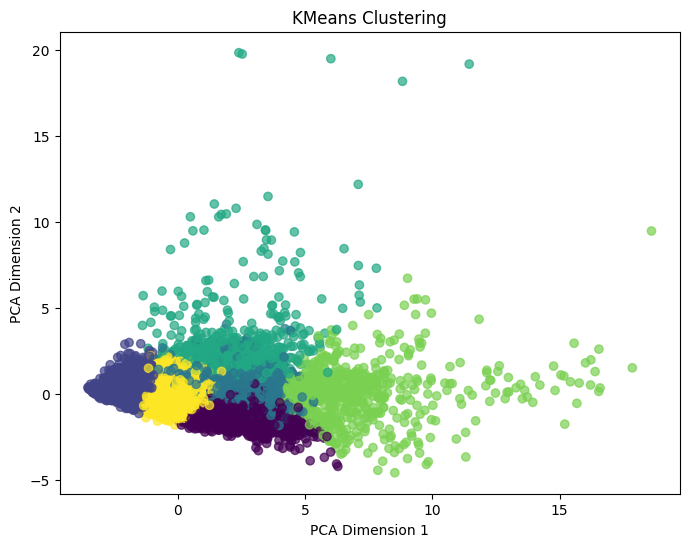

Silhouette Coefficient (KMeans): 0.18
Counter({np.int32(1): 5989, np.int32(5): 5316, np.int32(0): 2195, np.int32(2): 1447, np.int32(4): 758, np.int32(3): 717})


In [41]:
# 1. DBSCAN to identify spending clusters/categories
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
from sklearn import metrics
from sklearn.cluster import KMeans

# Aggregate user spending data per month
data = pd.read_csv("data/credit_card_transactions.csv")

# combine _pos (point of sale) and _net (online) transactions
category_mapping = {
    'grocery_pos': 'grocery',
    'grocery_net': 'grocery',
    'misc_net': 'misc',
    'misc_pos': 'misc',
    'shopping_pos': 'shopping',
    'shopping_net': 'shopping',
    'entertainment': 'entertainment',
    'food_dining': 'food_dining',
    'gas_transport': 'gas_transport',
    'health_fitness': 'health_fitness',
    'home': 'home',
    'kids_pets': 'kids_pets',
    'travel': 'travel',
    'personal_care': 'personal_care',
}
data['category_grouped'] = data['category'].map(category_mapping).fillna(data['category'])

# Split date into year and month for aggregation
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['year_month'] = data['trans_date_trans_time'].dt.to_period('M')

# Aggregate total amount spent per user per month
monthly_spending = data.groupby(['cc_num', 'year_month'])['amt'].sum().reset_index()
monthly_spending.rename(columns={'amt': 'total_spent'}, inplace=True)

# Aggregate total spend per user per category per month
categories = data['category_grouped'].unique()

for category in categories:
    filtered_data = data[data['category_grouped'] == category]
    monthly_category_spending = filtered_data.groupby(['cc_num', 'year_month'])['amt'].sum().reset_index(name=category)
    monthly_spending = monthly_spending.merge(monthly_category_spending, on=['cc_num', 'year_month'], how='left')

# replace NaN values with 0 (no spending in that category)
monthly_spending.fillna(0, inplace=True)

# Select features
features = ['total_spent'] + [category for category in categories]
X = monthly_spending[features].values

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply kmeans
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize KMeans Clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("KMeans Clustering")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

# Evaluate
sc = metrics.silhouette_score(X_scaled, kmeans_labels)
print("Silhouette Coefficient (KMeans): %0.2f" % sc)
print(Counter(kmeans_labels))

Analyze kmeans results

         total_spent      misc   grocery  entertainment  gas_transport  \
cluster                                                                  
0            7846.40  0.114073  0.182336       0.066112       0.142274   
1            2250.20  0.109199  0.188641       0.064901       0.106622   
2            9952.05  0.153499  0.176111       0.066974       0.048036   
3           11040.45  0.053435  0.131103       0.054575       0.038246   
4           16268.41  0.116633  0.224629       0.072065       0.048457   
5            4867.40  0.101229  0.188357       0.067178       0.111012   

         shopping  food_dining  personal_care  health_fitness    travel  \
cluster                                                                   
0        0.133999     0.050766       0.056804        0.063860  0.012305   
1        0.179660     0.054382       0.049578        0.050436  0.035690   
2        0.342354     0.036403       0.035458        0.035085  0.010778   
3        0.156212     0.042932  

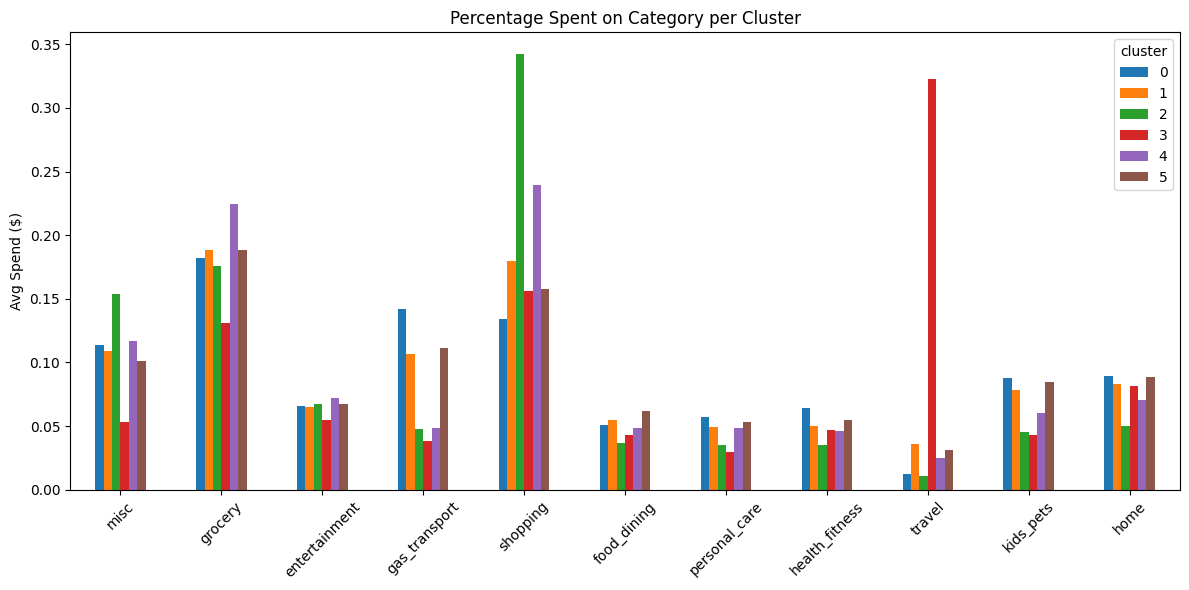

In [ ]:
monthly_spending["cluster"] = kmeans_labels
cluster_profiles = monthly_spending.groupby("cluster")[features + ['cluster']].mean().round(2)

# Define group names for clusters
cluster_names = {
    0: "Balanced Lifestyle Spender",
    1: "Low Spender",
    2: "Big Shopper",
    3: "High Home & Travel Spender",
    4: "High Spender",
    5: "Moderate Spender"

}

# For each cluster find the percentage of total spend in each category
for category in categories:
    cluster_profiles[category] = (cluster_profiles[category] / cluster_profiles['total_spent'])

# Map cluster number to cluster name
cluster_profiles['cluster_name'] = cluster_profiles['cluster'].map(cluster_names)
print(cluster_profiles)

cluster_profiles.drop(["total_spent", 'cluster', 'cluster_name'], axis=1).T.plot(kind='bar', figsize=(12,6))
plt.title("Percentage Spent on Category per Cluster")
plt.ylabel("Avg Spend ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

